---
---

# The Right Quarterback for Your NFL Franchise: The Draft Notebook
---
---

## Task 1 - The Data

In [1]:
# Cell for module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats
import math
import itertools
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering 
from sklearn.metrics import silhouette_score #, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", None)


In [2]:
# Load the data in a dataframe and show first 5 entries
raw_data = pd.read_csv("data/passer_stats_raw_data.csv", header=0) # 'index_col = 0' -> avoid column 'Unnamed: 0', which just is the index
raw_data.head(5)

,Unnamed: 0,Player,Tm,Age,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,Sk,Yds-s,Sk%,NY/A,ANY/A,Year
0,0,Kurt Warner,STL,30,16,16,375,546,68.7,4830,36,6.6,22,4.0,233,65,8.8,8.4,12.9,301.9,101.4,38,233,6.5,7.87,7.41,2001
1,1,Peyton Manning,IND,25,16,16,343,547,62.7,4131,26,4.8,23,4.2,201,86,7.6,6.6,12.0,258.2,84.1,29,232,5.0,6.77,5.88,2001
2,2,Brett Favre,GNB,32,16,16,314,510,61.6,3921,32,6.3,15,2.9,187,67,7.7,7.6,12.5,245.1,94.1,22,151,4.1,7.09,7.02,2001
3,3,Aaron Brooks,NOR,25,16,16,312,558,55.9,3832,26,4.7,22,3.9,182,63,6.9,6.0,12.3,239.5,76.4,50,330,8.2,5.76,4.99,2001
4,4,Rich Gannon,OAK,36,16,16,361,549,65.8,3828,27,4.9,9,1.6,195,49,7.0,7.2,10.6,239.3,95.5,27,155,4.7,6.38,6.61,2001


### Description of the Dataset

**Synonyms Used in This Notebook:**
- entry = record = row
- columns = features
- player = passer
- season = year


**The Dataset:**

This dataset contains NFL passer statistics from 2001 to 2023. Each entry corresponds to a single player in a specific season, so a player can appear multiple times in the dataset if he played in multiple seasons. The original dataset has 27 features - 14 integer, 11 decimal, and 2 string columns. The next cell provide an explanation of each column label and in task 2 the data type of each feature is shown. Most numeric features are counts (e.g., pass completions, pass attempts) and thus have no specific unit, although some columns represent percentages.

This dataset is suitable for the project because:
- With more than 2000 entries it contains enough records to perform meaningful analyses.
- It provides 27 columns (index column included) of which 25 are numeric, allowing for diverse exploratory analyses as well as retaining enough features after dimensionality reduction.
- Data quality is high, as there are no missing values.

However, I will perform additional preprocessing in Task 3 to tailor the data to my use case. This involves:
- Reordering and dropping certain columns.
- Calculating new features from existing ones.
- Reducing the dataset by applying a specific selection criterion to ensure (1) only quarterbacks remain, and (2) only those ones with a reasonable amount of pass attempts to make the evaluation reasonable.

This dataset is available as a CSV file on Kaggle, you can find the link down below (free sign-up required). The primary source is Pro Football Reference, an online statistics database for American football maintained by Sports Reference. However, for convenience I also provide the dataset for you in the folder 'data' under the name 'passer_stats_raw_data.csv'

Link to dataset on Kaggle: https://www.kaggle.com/datasets/rishabjadhav/nfl-passing-statistics-2001-2023
 

### All features with their respective meaning:

- **Unnamed: 0:** Index (row number, starting at 0) (can be avoided if specifying "index_col=0" when reading the CSV file)
- **Player:** Player's name
- **Tm:** Player's team during that season
- **Age:** Player's age 
- **G:** Number of games, in which the player played at some time of the game 
- **GS:** Number of games, in which the player started from the beginning of the game
- **Cmp:** Total completed passes (teammate caught the ball)
- **Att:** Total pass attempts (does NOT include sacks)
- **Cmp%:** Percentage of passes completed = $\frac{Cmp}{Att}$
- **Yds:** Total passing yards over all games of this season
- **TD:** Number of passes that resulted in a touchdown (teammate caught the pass in the endzone or run in after the catch)
- **TD%:** Percentage of touchdown passes = $\frac{TD}{Att}$
- **Int:** Number of passes intercepted by the opposing team 
- **Int%:** Percentage of interception passes = $\frac{Int}{Att}$
- **1D:** Number of passes that resulted in a new first down
- **Lng:** The longest completed pass (in yards) for that season
- **Y/A:** Average yards thrown per pass attempt = $\frac{Yds}{Att}$
- **AY/A:** Adjusted average yards thrown per pass attempt = $\frac{Yds\, +\, 20 \cdot TD\, -\, 45 \cdot Int}{Att}$
- **Y/C:** Average yards thrown per complete pass = $\frac{Yds}{Cmp}$
- **Y/G:** Average yards thrown per game = $\frac{Yds}{G}$
- **Rate:** Official NFL passer rating (scale: 0 = worst to 158.3 = best)
- **Sk:** Total number of sacks taken by the player
- **Yds-s:** Total yards lost due to sacks
- **Sk%:** Sack percentage = $\frac{Sk}{Att\, +\, Sk}$
- **NY/A:** Average net yards thrown per pass attempt = $\frac{Yds\, -\, Yds\text{-}s}{Att\, +\, Sk}$
- **ANY/A:** Adjusted average net yards thrown per pass attempt = $\frac{Yds\, +\, 20 \cdot TD\, -\, 45 \cdot Int\, -\, Yds\text{-}s}{Att\, +\, Sk}$
- **Year:** Year/Season of the entry

In [3]:
raw_data.Tm.unique()

array(['STL', 'IND', 'GNB', 'NOR', 'OAK', 'KAN', 'NYG', 'ARI', 'SFO',
       'SDG', 'TAM', 'TEN', 'JAX', 'MIA', 'PHI', 'CIN', 'PIT', 'CLE',
       'BAL', 'CAR', 'ATL', 'NWE', 'DEN', 'NYJ', 'MIN', 'DET', 'WAS',
       'CHI', 'BUF', 'SEA', 'DAL', 'HOU', '2TM', 'LAR', 'LAC', 'LVR',
       '3TM'], dtype=object)

In [4]:
raw_data[raw_data.Tm == '3TM']

,Unnamed: 0,Player,Tm,Age,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,Sk,Yds-s,Sk%,NY/A,ANY/A,Year
1509,1537,Travaris Cadet,3TM,26,7,1,0,1,0.0,0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,39.6,0,0,0.0,0.0,0.0,2015


## Task 2 - Initial Data Analysis

### Basic infos of the dataset

The following cells and outputs should give an overview of the dataset, e.g. the number of rows, columns, missing values, data types, and unique values in each column.

In [5]:
# Get shape of the dataset
raw_data.shape

(2350, 27)

$\Rightarrow$ The raw dataset contains 2350 rows and 27 columns

In [6]:
# Get more datailed information, e.g. data types of columns 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2350 non-null   int64  
 1   Player      2350 non-null   object 
 2   Tm          2350 non-null   object 
 3   Age         2350 non-null   int64  
 4   G           2350 non-null   int64  
 5   GS          2350 non-null   int64  
 6   Cmp         2350 non-null   int64  
 7   Att         2350 non-null   int64  
 8   Cmp%        2350 non-null   float64
 9   Yds         2350 non-null   int64  
 10  TD          2350 non-null   int64  
 11  TD%         2350 non-null   float64
 12  Int         2350 non-null   int64  
 13  Int%        2350 non-null   float64
 14  1D          2350 non-null   int64  
 15  Lng         2350 non-null   int64  
 16  Y/A         2350 non-null   float64
 17  AY/A        2350 non-null   float64
 18  Y/C         2350 non-null   float64
 19  Y/G         2350 non-null  

$\Rightarrow$ As mentioned before, no missing values and 25 numerical features

In [7]:
# Show how many unique values there are in each column 
raw_data.nunique()

Unnamed: 0    2350
Player         715
Tm              37
Age             25
G               17
GS              18
Cmp            406
Att            551
Cmp%           297
Yds           1210
TD              49
TD%            105
Int             30
Int%           108
1D             257
Lng            107
Y/A            191
AY/A           261
Y/C            196
Y/G           1152
Rate           688
Sk              63
Yds-s          334
Sk%            173
NY/A           637
ANY/A          796
Year            23
dtype: int64

## Task 3 - Preprocessing

Before applying the preprocessing steps, let's define a method to change a column position in a dataframe, which will be used for this task:

In [8]:
def change_col_pos(df, col, col_label, after_col, inplace=False):
    """
    Change the position/index of a column in a dataframe.

    Parameters:
    ----------
    df : DataFrame
        The dataframe that contains the column to change.
    
    col : String
        Current label of the column, which position should be changed.
    
    col_label : String
        New label of the column, which position should be changed. This will be the label for the column at the new position.

    after_col : String
        Label of the column, after which col will be placed. In the modified dataframe col_label (col) is the right neighbor of after_col. 
    
    inplace : Boolean
        If False, return the modified dataframe. Otherwise, do operation in place and return None.
    Returns:
    ----------
    DataFrame
        The modified dataframe with the new position of col with the label 'col_label'.
    """

    new_idx = df.columns.get_loc(f'{after_col}') + 1
    col = df.pop(f'{col}')
    df.insert(new_idx, f'{col_label}', col)
    if not inplace:
        return df

1\. Drop all players with less than 224 pass attempts in the respective season:
- Reason: 14 passes per game over a 16-game season are required to occur on the official NFL passer leaderboard for that year
- I will not be as strict, meaning that I don't require 14 passes in every single game but 14 passes in average per game
- This results in 224 pass attempts per season, because $\frac{224\, pass\, attempts}{16\, games}$ = $\frac{14\, pass\, attempts}{game}$
- It also ensures only quarterbacks remain in the dataframe

In [9]:
# 1. Drop players with less than 225 pass attempts
data = raw_data.copy()
mask = data['Att']>=224
data = data[mask].reset_index(drop=True)

2\. Remove some features from the dataframe 'data', which will be used for the following tasks. Except one, we will still keep all of these in a separate dataframe called 'side_data', so they can be used for later evaluations. The mentioned columns are the following:

- 'Unnamed: 0', because this is just the index column of 'raw_data' $\Rightarrow$ **will not be kept with the others**
- 'Player', because this is just the player name (can't be used as index because some players occur multiple times)
- 'Tm', because this is just the team/franchise name $\Rightarrow$ clustering could group similar teams rather than similar passers
- 'Year', because clustering could group potential outside effects over time (e.g. rule changes) rather than similar passers

In [10]:
# 2. Remove features and keep all of them separately (except 'Unnamed: 0')
side_data = data[['Player', 'Tm', 'Year']].copy()
drop_cols = ['Unnamed: 0', 'Player', 'Tm', 'Year']
data.drop(columns=drop_cols, inplace=True)

3\. Adding a new feature $1D\%$, which represents the percentage of first downs. This is the total number of first downs per total pass attempts + sacks (calculation according to feature $Sk\%$): 

$1D\%$ = $\frac{First Downs}{Pass\, Attempts\, + \, Sacks}$ = $\frac{1D}{Att\, +\, Sk}$

In [11]:
# 3. Adding the new feature '1D%' (first down percentage) and place the column after the '1D' feature
data['1D%'] = (data['1D'] / (data['Att'] + data['Sk'])) * 100
data['1D%'] = data['1D%'].round(1) 
change_col_pos(data, '1D%', '1D%', '1D', inplace=True)

4\. Revising the calculation of the touchdown rate feature $TD\%$. Currently it's the total number of touchdowns per pass attempts:

$TD\%$ = $\frac{Touchdowns}{Pass\, Attempts}$ = $\frac{TD}{Att}$

However, in my opinion the calculation should follow the same rules like for features $Sk\%$ and $1D\%$ (see 3.), This is more consistent, as all efficiency metrics will then have the same drop‑back denominator. So a new feature $TD\%\_new$ will be calculated with the following formula:

$TD\%\_new$ = $\frac{Touchdowns}{Pass\, Attempts\, + \, Sacks}$ = $\frac{TD}{Att\, +\, Sk}$ 

After creating this new feature, three different correlation coeffcients between $TD\%$ and $TD\%\_new$ will be evaluated. If there is high correlation it's reasonable to drop one of these two features, because no additional information would be added by having both. In this case $TD\%$ would be dropped and $TD\%\_new$ would be kept for the consistency reasons I already mentioned. But if there is no correlation both features will remain.

In [12]:
# 4.1 Creating the feature 'TD%_new' and adding it to the 'data' dataframe
data['TD%_new'] = (data['TD'] / (data['Att'] + data['Sk'])) * 100
data['TD%_new'] = data['TD%_new'].round(1)
change_col_pos(data, 'TD%_new', 'TD%_new', 'TD%', inplace=True)

In [13]:
# 4.2 Calculating different correlation coefficients
x = scipy.stats.pearsonr(data['TD%'], data['TD%_new']) 
y = scipy.stats.spearmanr(data['TD%'], data['TD%_new']) 
z = scipy.stats.kendalltau(data['TD%'], data['TD%_new']) 
x, y, z

(PearsonRResult(statistic=np.float64(0.9972233697871886), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.9968457076932465), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.9711086836579708), pvalue=np.float64(0.0)))

**Observation:** Very high correlation with near-zero p-values between $TD\%$ and $TD\%\_new$ $\Rightarrow$ drop $TD\%$ as explained before

In [14]:
# 4.3 Dropping the initial 'TD%' feature as there is very high (linear) correlation with 'TD%_new'
data.drop(columns=['TD%'], inplace=True)

5\. For the final preprocessing step I will just reorder some columns for a more logical order.

In [15]:
# 5. Reorder columns
change_col_pos(data, 'Att', 'Att', 'GS', inplace=True)
change_col_pos(data, 'Sk%', 'Sk%', 'Sk', inplace=True)

cols_to_find = ['Y/A', 'AY/A', 'Y/C', 'Y/G', 'NY/A', 'ANY/A']
temporary_df = data[cols_to_find].copy()
data.drop(columns=cols_to_find, inplace=True)
data = pd.concat([data, temporary_df], axis=1)

### Let's check the final dataframe 'data', which will be used for the following tasks

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      753 non-null    int64  
 1   G        753 non-null    int64  
 2   GS       753 non-null    int64  
 3   Att      753 non-null    int64  
 4   Cmp      753 non-null    int64  
 5   Cmp%     753 non-null    float64
 6   Yds      753 non-null    int64  
 7   TD       753 non-null    int64  
 8   TD%_new  753 non-null    float64
 9   Int      753 non-null    int64  
 10  Int%     753 non-null    float64
 11  1D       753 non-null    int64  
 12  1D%      753 non-null    float64
 13  Lng      753 non-null    int64  
 14  Rate     753 non-null    float64
 15  Sk       753 non-null    int64  
 16  Sk%      753 non-null    float64
 17  Yds-s    753 non-null    int64  
 18  Y/A      753 non-null    float64
 19  AY/A     753 non-null    float64
 20  Y/C      753 non-null    float64
 21  Y/G      753 non

**Observation:** Overall 753 entries (passer-season data points) and 24 features remain after preprocessing and all are of a numerical type. Also, as before there no missing values.

## Task 4 - Exploratory Data Analysis: Statistical Properties

### Analysis 1: Statistical metrics of the features

In [17]:
data.describe().round(2)

,Age,G,GS,Att,Cmp,Cmp%,Yds,TD,TD%_new,Int,Int%,1D,1D%,Lng,Rate,Sk,Sk%,Yds-s,Y/A,AY/A,Y/C,Y/G,NY/A,ANY/A
count,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00,753.00
mean,28.60,13.98,13.58,453.73,283.93,62.18,3240.90,20.11,4.07,11.50,2.59,156.95,32.07,68.99,87.11,29.88,6.35,195.35,7.10,6.80,11.42,229.34,6.23,5.96
std,4.63,2.65,3.08,116.60,81.55,4.52,959.32,8.78,1.25,4.49,0.93,48.96,4.27,12.48,11.88,10.38,2.07,71.95,0.77,1.17,0.96,41.62,0.81,1.19
min,21.00,6.00,5.00,224.00,113.00,46.50,1194.00,3.00,0.90,1.00,0.30,0.00,0.00,35.00,50.00,6.00,1.60,32.00,5.00,3.50,8.60,107.30,3.87,2.31
25%,25.00,12.00,11.00,366.00,218.00,59.40,2464.00,13.00,3.20,8.00,1.90,118.00,29.40,60.00,78.50,23.00,4.90,145.00,6.60,6.00,10.80,200.30,5.71,5.12
50%,28.00,15.00,15.00,469.00,289.00,62.30,3291.00,19.00,3.90,11.00,2.50,160.00,32.00,70.00,87.00,29.00,6.20,188.00,7.00,6.80,11.40,229.60,6.18,5.93
75%,32.00,16.00,16.00,545.00,347.00,65.60,4002.00,26.00,4.80,14.00,3.20,192.00,34.80,78.00,95.20,36.00,7.60,237.00,7.60,7.50,12.00,259.80,6.81,6.76
max,45.00,17.00,17.00,733.00,490.00,74.40,5477.00,55.00,9.60,30.00,6.20,291.00,45.70,99.00,122.50,76.00,14.70,477.00,9.60,10.50,14.70,342.30,8.81,9.78


### Analysis 2: Correlation plot of all features

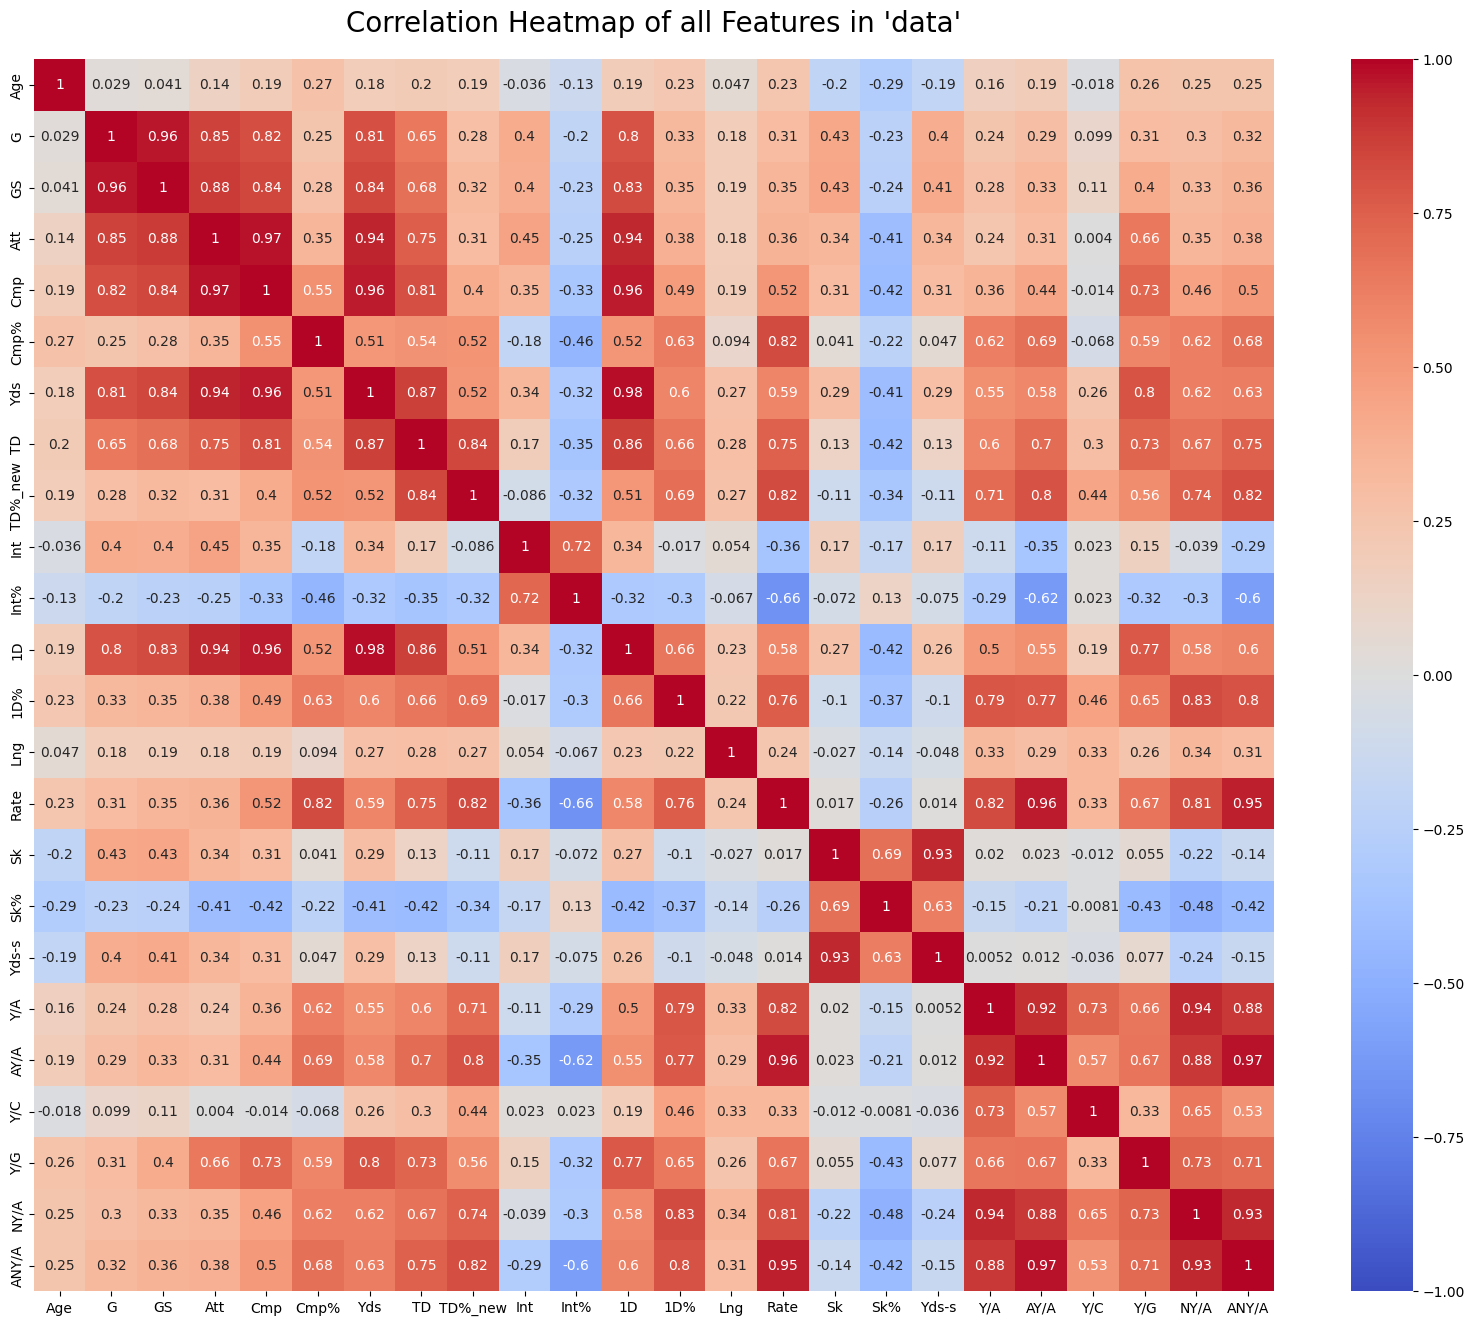

In [18]:
# Correlation plot of all features
fig= plt.figure(figsize=(20, 16))
corr_matrix = data.corr(method='pearson') # using pearson to inspect linear correlations 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of all Features in 'data'", pad=20.0, fontdict={'fontsize':20})
plt.show()

**Observations:**
- Age ('AG') doesn't have any strong linear correlation with other features $\Rightarrow$ maybe an indication for "age doesn't matter"
- Both Games Started ('GS') and Pass Attempts ('Att') seem to have a relative high correlation with the total number of Touchdowns ('TD') but not with Interceptions ('INT') $\Rightarrow$ so more games and attempts might have a bigger impact on the positive results rather than on negative metrics
- Both Total Number of Sacks ('Sk') and Sack Percentage ('Sk%') don't have any meaningful linear correlation with other features, so this metric might not be an important factor in passer evaluation/ranking $\Rightarrow$ might be obvious as a passer doesn't get the chance to throw the ball if he gets sacked by the opposing team, however someone might think that more sacks could influence the pass performance (e.g. psychological reasons)

### Analysis 3: Boxplots of four selected features

Compute boxplots for *Age*, *Yds*, *Cmp%*, and Rate giving a brief insight into their distributions. These features are not necessarily the (only) ones we’ll focus on subsequently, but they provide an early picture of how some of the data is spread out.

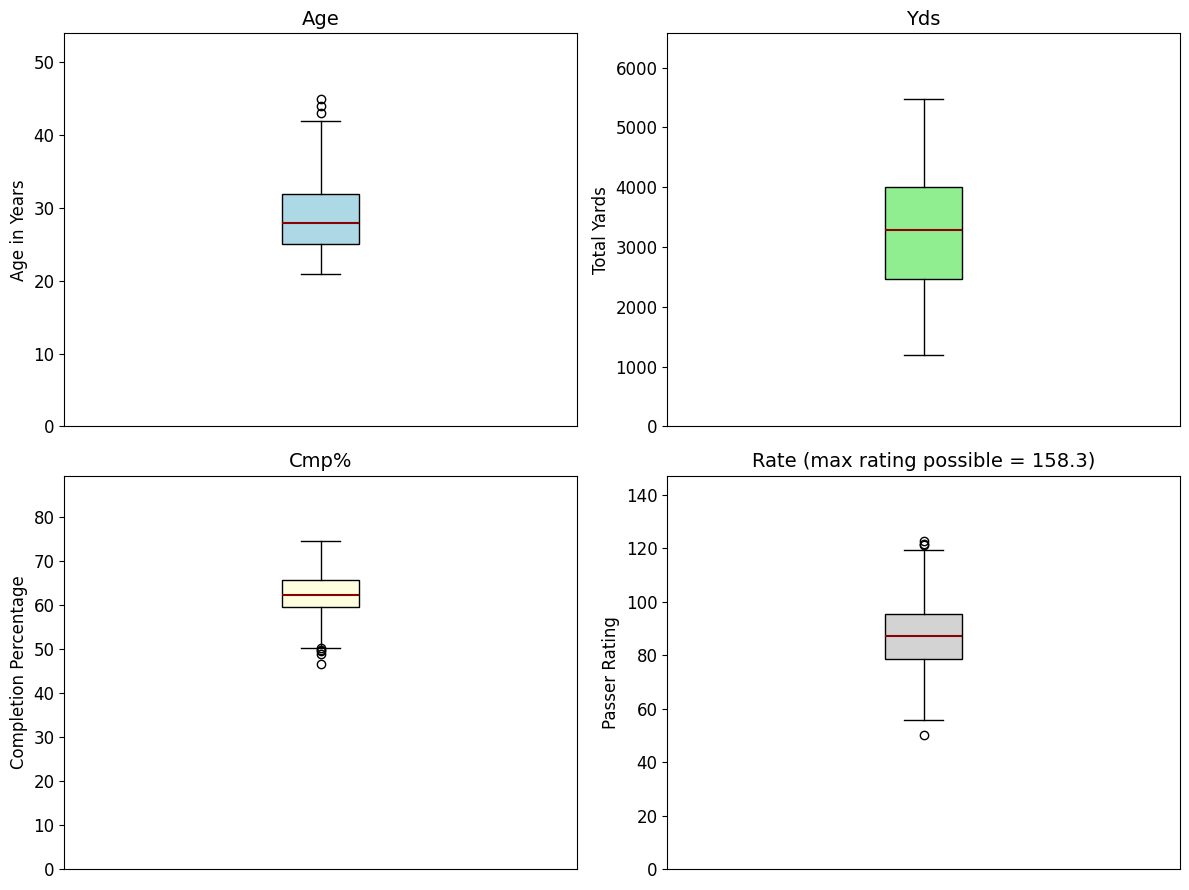

In [19]:
# Define features and colors for boxplots
features = [
    ('Age', 'Age in Years', 'lightblue'),
    ('Yds', 'Total Yards', 'lightgreen'),
    ('Cmp%', 'Completion Percentage', 'lightyellow'),
    ('Rate', 'Passer Rating', 'lightgrey')
]

# Determine number of features
n_features = len(features)

plt.figure(figsize=(3*n_features, 2.25*n_features))
n_rows, n_cols = 2, 2

# Iterate over features and create one subplot per feature
for i, (feature, label, color) in enumerate(features, start=1):
    ax = plt.subplot(n_rows, n_cols, i)
    bp = ax.boxplot(data[feature].dropna(), patch_artist=True)
    # Set the face color for the box
    for box in bp['boxes']:
        box.set(facecolor=color)
    # Set median line properties: dark red and increased linewidth
    for median in bp['medians']:
        median.set(color='darkred', linewidth=1.5)
    ax.set_title(feature if feature != 'Rate' else 'Rate (max rating possible = 158.3)', fontdict={'fontsize':14})
    ax.set_xticks([])  # Remove x-axis tick labels
    ax.set_ylim(bottom=0, top=1.2*max(data[feature]))   #ylim([0, 1.1])
    # Set the y-axis 
    ax.set_ylabel(label, fontdict={'fontsize':12})
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

### Analysis 4: Histogram, boxplot, and cumulative distribution table of Average Net Yards per Attempt ('ANY/A')

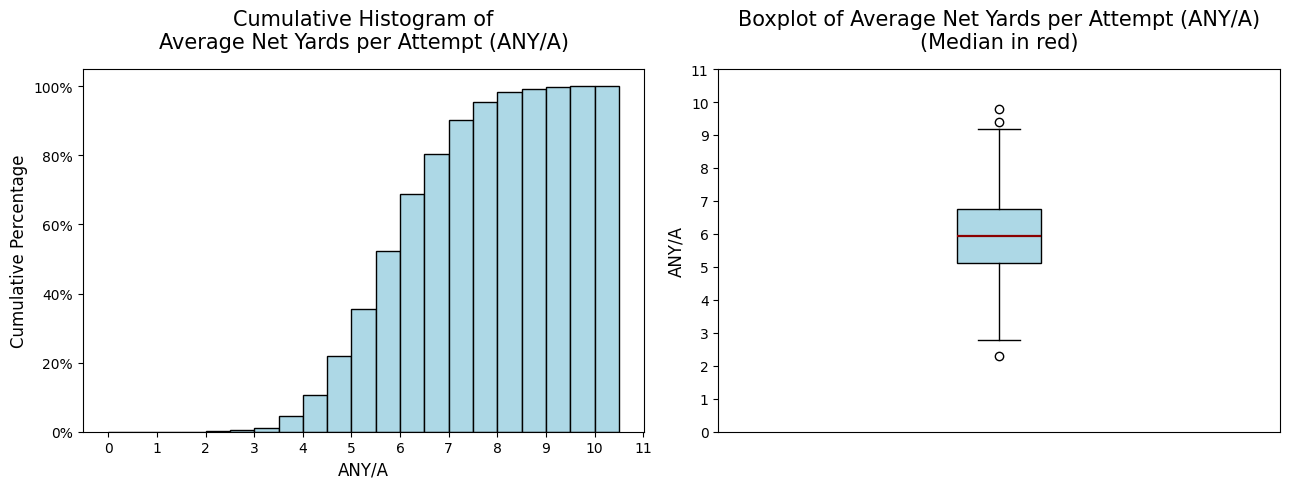

In [20]:
max_ANYA = max(data['ANY/A'])
start_x = 0
stop_x  = math.ceil(max_ANYA) + 1
step_x  = 0.5
x_range = [start_x + i * step_x for i in range(int((stop_x-start_x)/step_x))]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5)) 

ax1.hist(data['ANY/A'], cumulative=True, weights=np.ones(len(data)) / len(data), bins=x_range, color='lightblue', edgecolor='black') 
ax1.set_title("Cumulative Histogram of\nAverage Net Yards per Attempt (ANY/A)", fontsize=15, pad=15) 
ax1.set_xlabel('ANY/A', fontsize=12) 
ax1.set_xticks(range(12))
ax1.set_ylabel('Cumulative Percentage', fontsize=12) 
ax1.set_yticks(np.arange(0, 1.1, 0.20))          
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

bp = ax2.boxplot(data['ANY/A'], patch_artist=True)
for box in zip(bp['boxes'],bp['medians']):
    box[0].set(facecolor='lightblue')
    box[1].set(color='darkred', linewidth=1.6)
ax2.set_title('Boxplot of Average Net Yards per Attempt (ANY/A)\n(Median in red)', fontsize=15, pad=15)
ax2.set_xticks([])  # Remove x-axis tick labels
ax2.set_ylabel('ANY/A', fontsize=12)
ax2.set_yticks(range(12))

plt.tight_layout()
plt.show()

# Series of ANY/A values and same bin edges as in the histogram
anya = data['ANY/A']
bin_edges = x_range           
hist_counts = np.histogram(anya, bins=bin_edges)[0]

# Convert counts to cumulative counts
cum_pct = np.cumsum(hist_counts) / len(anya) * 100

# Build the cumulative distribution dataframe
cdf_table = pd.DataFrame({
    'ANY/A ≤': bin_edges[1:], # upper edge of each bin
    'Cumulative %': cum_pct
})

**Observations:** 
- The majority of passers (around 80%) achieve ≤ 7.0 net yards per attempt
- 50% of the passers have an ANY/A of just under 6 yards
    
    $\Rightarrow$ For ANY/A just 1 yard is a huge difference
- Generally the distribution of ANY/A is symmetric, as the median is in the center of the box (same distnace between Q1-Q2 and Q2-Q3) and the whiskers are of equal length
- Very few outliers, which are neglectable

### Analysis 5: Pass Attempts vs. Rating scatter plot with color encoded Touchdown Percentage

Visualize how a passer is graded by the NFL passer rating with increasing pass attempts and how touchdown percentage fits into the picture.

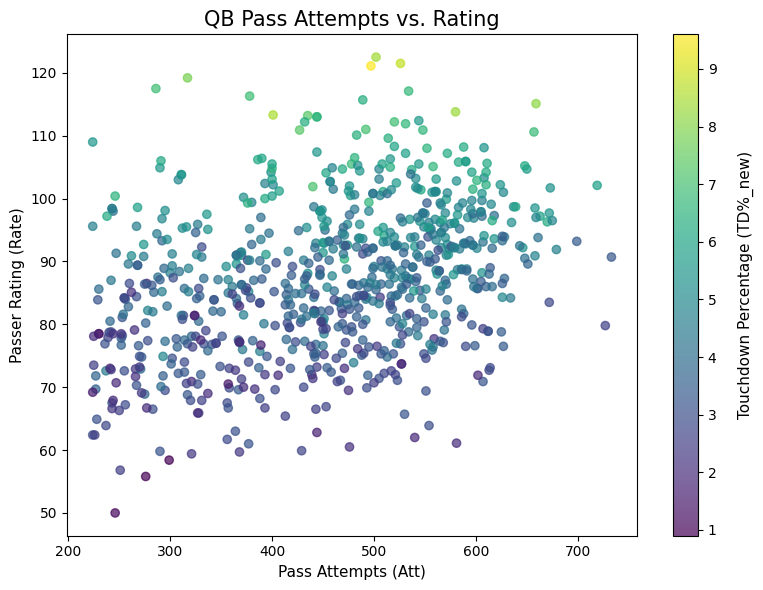

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(data['Att'], data['Rate'], 
                     c=data['TD%_new'], # colour‑encode by touchdown efficiency 
                     cmap='viridis', alpha=0.7)

ax.set_xlabel('Pass Attempts (Att)', fontsize = 11)
ax.set_ylabel('Passer Rating (Rate)', fontsize = 11)
ax.set_title('QB Pass Attempts vs. Rating', fontsize=15)
cbar = fig.colorbar(scatter)
cbar.set_label('Touchdown Percentage (TD%_new)',  fontsize=11, labelpad=15)

fig.tight_layout()
plt.show()

**Observations:**
- It doesn't seem that a passer gets a significant higher passer rating with more pass attempts, as with increasing attempts there is just a little shift of the data cloud to the upside
- The passers with a high passer rating also have a high touchdown percentage, which was expected as touchdowns are an important factor for the calculation of 'Rate'
- Overall more pass attempts (more playing experience) don't seem to increase the other 2 performance metrics 

### Analysis 6: Average efficiency metrics for each quartile of Attempts ('Att')

Order the values of the feature Pass Attempts ('Att') in ascending order and split this ordered data into the 4 quartiles. For each quartile´four mean values are computed: the means of 'Rate', 'TD%_new', 'Int%', 'Sk%'. Below they are shown in a table and visualized with plots.

,Rate,TD%_new,Int%,Sk%
Att_quartile,,,,
Q1,80.83,3.51,2.97,7.35
Q2,85.94,3.94,2.63,6.83
Q3,89.65,4.30,2.45,6.10
Q4,92.10,4.52,2.33,5.12


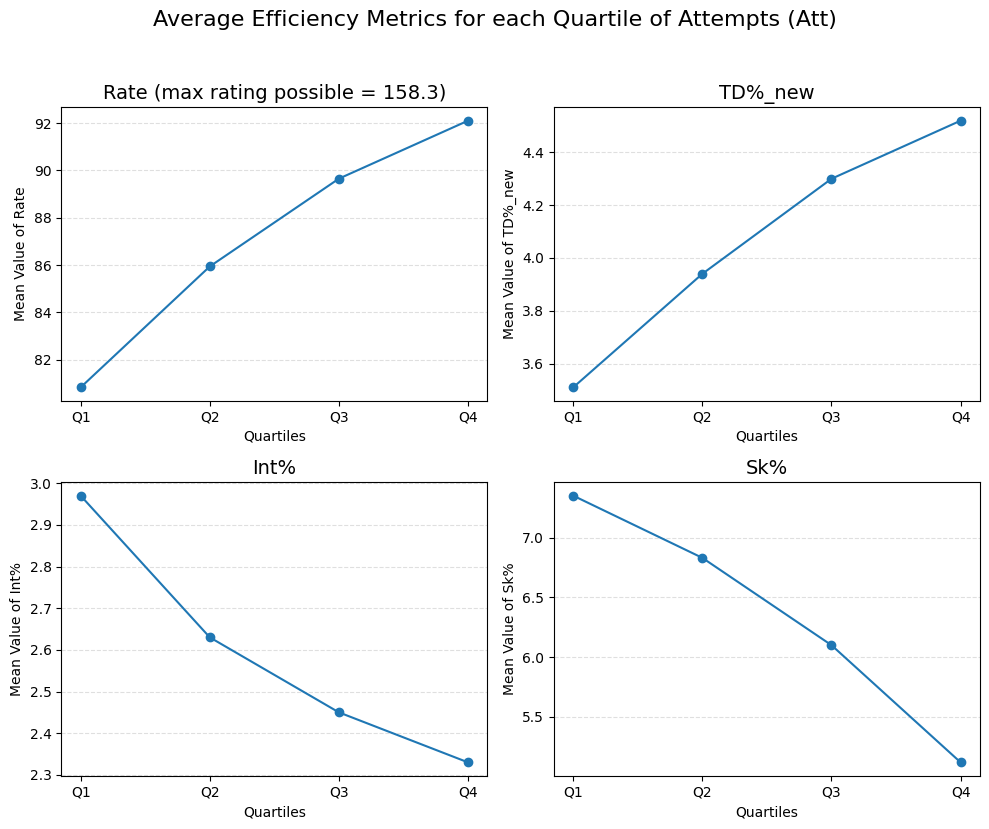

In [22]:
# 1.  Label workload quartiles 
Att_quartiles = data[['Att','Rate', 'TD%_new', 'Int%', 'Sk%']].copy()
Att_quartiles['Att_quartile'] = pd.qcut(Att_quartiles['Att'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# 2.  Aggregate mean efficiency metrics
metrics = ['Rate', 'TD%_new', 'Int%', 'Sk%']
quartile_stats = (
    Att_quartiles.groupby('Att_quartile', observed=False)[metrics]
        .mean()
        .round(2)
)
display(quartile_stats)

n_rows, n_cols = 2, 2   
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8), sharex=False)
axes = axes.flatten() # Flatten axes array for easy iteration

for ax, metric in zip(axes, metrics):
    # x‑positions for quartiles (0,1,2,3) and corresponding mean values
    x = range(len(quartile_stats))
    y = quartile_stats[metric].values
    
    # Draw a thin line and put a solid marker on each mean
    ax.plot(x, y, marker='o', linewidth=1.5)
    
    # Labeling
    ax.set_xticks(x)
    ax.set_xticklabels(quartile_stats.index, rotation=0)
    ax.set_title(metric if metric != 'Rate' else 'Rate (max rating possible = 158.3)', fontdict={'fontsize':14}) 
    ax.set_xlabel('Quartiles', fontdict={'fontsize':10})
    ax.set_ylabel(f'Mean Value of {metric}', fontdict={'fontsize':10})
    
    # Optional: add grid for readability
    ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle('Average Efficiency Metrics for each Quartile of Attempts (Att)', y=1.03, fontsize=16)
plt.tight_layout()
plt.show()

**Observations:**
- Passers with many pass attempts also have a higher touchdown percentage and passer rating, while their sack and interception percentages are lower
- So Passers belonging to a higher 'Att' quartile seem to perform "better"

## Task 5 - Dimensionality Reduction

### Criteria/Goals for retaining principal components
- Each retained PC should explain ≥ 5 % of the total variance, as the original feature space is quite rich with 24 features.
- The retained set should account for at least 80 % of the cumulative variance.

**These thresholds should balance information retention with dimensionality reduction.**

### First Step before PCA: Scaling the data 

In [23]:
# Scale the data before applying PCA
scaler_1 = StandardScaler()
data_sc_1 = scaler_1.fit_transform(data)
data_sc_1 = pd.DataFrame(data_sc_1, index=data.index, columns=data.columns) 
data_sc_1.head(5)

,Age,G,GS,Att,Cmp,Cmp%,Yds,TD,TD%_new,Int,Int%,1D,1D%,Lng,Rate,Sk,Sk%,Yds-s,Y/A,AY/A,Y/C,Y/G,NY/A,ANY/A
0,0.301742,0.76031,0.787948,0.791879,1.117381,1.444820,1.657596,1.810593,1.704702,2.341158,1.510099,1.554288,1.832646,-0.320101,1.203102,0.782318,0.071552,0.523575,2.227302,1.372480,1.541447,1.744458,2.017563,1.227489
1,-0.778162,0.76031,0.787948,0.800461,0.724742,0.115864,0.928469,0.670932,0.345167,2.564083,1.724850,0.900263,0.661720,1.363784,-0.253671,-0.085118,-0.651971,0.509667,0.658153,-0.167852,0.604636,0.693814,0.661442,-0.063443
2,0.733704,0.76031,0.787948,0.482927,0.368913,-0.127777,0.709418,1.354728,1.544757,0.780682,0.328971,0.614126,0.731976,-0.159731,0.588394,-0.759791,-1.086085,-0.616806,0.788916,0.687888,1.125087,0.378861,1.055950,0.898428
3,-0.778162,0.76031,0.787948,0.894862,0.344374,-1.390285,0.616582,0.670932,0.185222,2.341158,1.402724,0.511935,-0.509205,-0.480471,-0.902061,1.938899,0.891544,1.872561,-0.257183,-0.681297,0.916906,0.244225,-0.583723,-0.814378
4,1.597627,0.76031,0.787948,0.817625,0.945601,0.802491,0.612410,0.784898,0.505113,-0.556869,-1.066909,0.777633,0.427535,-1.603061,0.706283,-0.277882,-0.796676,-0.561177,-0.126421,0.345592,-0.852627,0.239416,0.180636,0.552492


### Applying PCA to 'data'

In [24]:
first_pca = PCA()
data_pca_unred = first_pca.fit_transform(data_sc_1) # unred = unreduced
data_pca_unred = pd.DataFrame(data_pca_unred, index=data.index)
data_pca_unred.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,5.707013,0.572508,-0.287112,2.727195,-2.498428,-0.906627,-0.221911,0.471148,0.045279,-0.256437,-0.214428,0.026187,-0.179950,-0.165160,0.243305,0.011746,0.093984,0.006120,0.061704,0.030877,0.000475,0.051310,-0.012927,-0.004671
1,1.996791,1.946587,-1.731920,2.562827,-0.283619,-0.101207,-1.285107,0.267243,-0.247942,-0.001148,0.501597,-0.011250,-0.077016,-0.285481,0.114039,0.005053,0.068122,-0.033025,-0.008942,0.030654,0.024314,-0.025359,0.010249,0.000482
2,3.071178,-0.538236,-1.542161,0.981481,-0.039414,-0.421004,1.140352,0.781105,0.428885,-0.205688,0.114777,0.023801,0.022349,-0.108191,0.061152,0.050183,-0.031806,0.000614,0.013568,-0.017438,0.008568,-0.040304,-0.011425,-0.004670
3,-0.224912,3.976784,0.503425,2.525423,-0.629531,-0.533471,0.490033,0.061945,1.180971,-0.049141,0.160470,0.182928,-0.334671,-0.082590,0.149328,-0.017951,-0.076501,0.019018,-0.016077,-0.045517,0.011842,-0.056922,-0.002860,0.007799
4,2.242260,0.179684,-0.700907,-2.541662,-0.682520,-0.338776,1.404657,0.322791,-0.042298,-0.022854,-0.320535,0.024012,0.088831,0.046908,-0.049386,-0.014982,-0.044838,0.013038,-0.020430,0.009621,0.039548,-0.034591,-0.013439,-0.001497


### Let's have a look on the covariance matrix of 'data_pca_unred'

In [25]:
data_pca_unred.cov().round(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,11.3291,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000
1,0.0000,4.3303,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
2,0.0000,-0.0000,2.4409,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
3,-0.0000,-0.0000,0.0000,1.8417,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000
4,0.0000,-0.0000,0.0000,0.0000,1.0073,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
5,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.8403,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.6898,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000
7,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.5708,-0.0000,-0.0000,0.0000,0.0000,0.000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
8,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.4737,0.0000,0.0000,0.0000,-0.000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000
9,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.2568,-0.0000,-0.0000,0.000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000


### Now let's find out how much of the total variance the individual principal components hold

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Indiv. expl. VAR,0.47,0.18,0.10,0.08,0.04,0.03,0.03,0.02,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Accum. expl. VAR,0.47,0.65,0.75,0.83,0.87,0.91,0.94,0.96,0.98,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Keeping 4 components (83.0% variance)


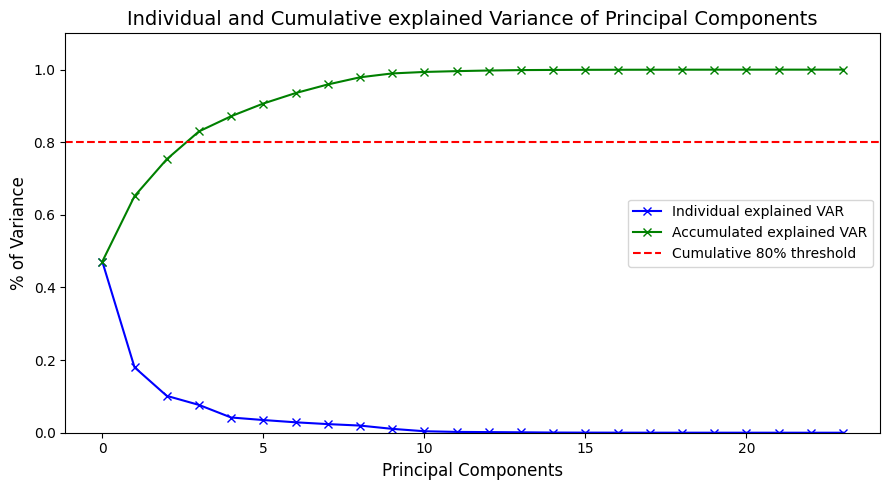

In [26]:
expl_var_ratio=first_pca.explained_variance_ratio_
accum_expl_var = np.add.accumulate(expl_var_ratio)

expl_var_df = pd.DataFrame({'Indiv. expl. VAR':expl_var_ratio, 'Accum. expl. VAR':accum_expl_var})
display(expl_var_df.T.round(2).style.format("{:.2f}"))

# Set a threshold for how much of the total variance should explained by the kept PCs: 80%
n = np.argmax(accum_expl_var >= 0.80) + 1 # n will be used in the next step too
print(f"Keeping {n} components ({accum_expl_var[n-1]:.1%} variance)")

plt.figure(figsize=(9,5))
plt.plot(expl_var_ratio, marker='x', label='Individual explained VAR', c='blue')
plt.plot(accum_expl_var, marker='x', label='Accumulated explained VAR', c='green')
plt.axhline(0.80, color='red', linestyle='--', label= 'Cumulative 80% threshold')
plt.ylim([0, 1.1])
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('% of Variance', fontsize=12)
plt.title('Individual and Cumulative explained Variance of Principal Components', fontsize=14)
plt.tight_layout()
plt.legend(loc='center right')

**Observations:**
- PC 1 explains almost half (≈ 47%) of the total variance.
- Just the first 4 principal components each account for at least 5% of the overall explained variance.
- The first 4 principal components together account for ≈ 83% of the cumulative variance. Also, 4 components are needed to meet the criteria of keeping at least 80% of the total variance.

**Conclusion**: The first 4 prinicipal components are retained, as each of them contribute at least 5% to the overall variance. Together they make up ≈ 83% of the total variance. So by keeping the first 4 components the selection criteria mentioned at the beginning are met.

### Applying the selected PCA transformation (first 4 PC) and call the result 'data_pca'

In [27]:
final_pca = PCA(n_components=n) # n was defined in the last code cell
data_pca = final_pca.fit_transform(data_sc_1)

data_pca  = pd.DataFrame(
    data_pca,
    index=data.index,
    columns=[f'PC{i+1}' for i in range(n)]
)
data_pca.head(5)

,PC1,PC2,PC3,PC4
0,5.707013,0.572508,-0.287112,2.727195
1,1.996791,1.946587,-1.731920,2.562827
2,3.071178,-0.538236,-1.542161,0.981481
3,-0.224912,3.976784,0.503425,2.525423
4,2.242260,0.179684,-0.700907,-2.541662


### Finally let's inspect the highest loading for each of the final 4 PC in 'data_pca', meaning which of the original features contribute the most to PC1-PC4

In [28]:
loadings = pd.DataFrame(
    final_pca.components_.T,
    index=data.columns,
    columns=data_pca.columns
).round(2)

for pc in data_pca.columns:
    max_load_ft = loadings[pc].max()
    features = [feature for feature in loadings[loadings[pc] == loadings[pc].max()].index]
    print(f'Highest loading for {pc} = {max_load_ft} from feature(s): {', '.join(features)}')  

Highest loading for PC1 = 0.27 from feature(s): Yds, TD, ANY/A
Highest loading for PC2 = 0.32 from feature(s): Sk, Yds-s
Highest loading for PC3 = 0.52 from feature(s): Sk%
Highest loading for PC4 = 0.55 from feature(s): Y/C


## Task 6 - Exploratory Data Analysis: Clustering

### Choice of Algorithms: Family a) k-Means++ | Family b) OPTICS | Family c) HAC
### First all clustering families will be evaluated for 'data' and after that all clustering families will be evaluated for 'data_pca'

### 1. Clusterings for 'data'

Before applying clustering 'data' will also be scaled with StandardScaler because:
- **Unit-variance features:** k-Means++, OPTICS, and HAC rely on euclidean distance $\Rightarrow$ Z-scoring prevents large-scale variables such as 'Yds' or 'Att' from dwarfing smaller-scale metrics like percentages.
- **Consistency with the PCA run:** Keeping the same scaling method lets us compare cluster quality on data and data_pca without a hidden scale bias.
- **Better outlier handling than Min-Max:** MinMaxScaler stretches the 0-to-1 range to include extreme outliers 
- **Conventional choice for mixed-unit numeric data:** Z-scoring is the standard preprocessing step recommended in the scikit-learn documentation for distance-based clustering on heterogeneous feature sets

**All clusterings use euclidean distance. After z-scoring, euclidean treats each standard-deviation change equally and is required for k-Means++ and Ward linkage. So using the same metric for different clustering algorithms ensures comparability. For all clusterings with the respective combinations of hyperparameters the silhouette score will be computed to find the best clustering.**

In [29]:
# Scale raw 'data'
scaler_2 = StandardScaler()
data_sc_2 = scaler_2.fit_transform(data)
results_data = [] # collect evaluation data for 'data' clusterings

random_state = 42
n_init = 30
init = 'k-means++'
k_values = list(range(2,7))     # k-values for k-Means++ and HAC
MinPts_low, MinPts_max = 4, 7   # different MinPts values for OPTICS
xis = [0.03, 0.05, 0.08]        # different xi values for OPTICS
linkages = ['ward', 'average']  # link options for HAC

### 1.1 k-Means++
#### Hyperparamters: different k-values for the number of clusters

In [30]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=random_state)
    kmean_labels = kmeans.fit_predict(data_sc_2)
    kmeans_silh_score = silhouette_score(data_sc_2, kmean_labels, metric='euclidean')
    results_data.append({'Algorithm':'k-Means++', 'k':k, 'MinPts':'-', 'ε':'-', 'Silhouette':kmeans_silh_score})

### 1.2 OPTICS
#### Hyperparamters: different values for MinPts and ε (xi)

In [31]:
for MinPts in range(MinPts_low, MinPts_max+1):
    for xi in xis:
        opt = OPTICS(min_samples=MinPts, xi=xi)
        opt_labels = opt.fit_predict(data_sc_2)
        opt_silh_score = silhouette_score(data_sc_2, opt_labels, metric='euclidean') if len(set(opt_labels)) > 1 else np.nan
        results_data.append({'Algorithm':'OPTICS', 'k':'-', 'MinPts':MinPts, 'ε':xi, 'Silhouette':opt_silh_score})

### 1.3 HAC
#### Hyperparamters: ward- and average-link; for each linkage evaluate the same k-values as for k-Means++

In [32]:
for link in linkages: 
    for k in k_values:
        hac = AgglomerativeClustering(n_clusters=k, linkage=link)
        hac_labels = hac.fit_predict(data_sc_2)
        hac_silh_score = silhouette_score(data_sc_2, hac_labels, metric='euclidean') if len(set(hac_labels)) > 1 else np.nan
        results_data.append({'Algorithm':f'HAC_{link}', 'k':k, 'MinPts':'-', 'ε':'-', 'Silhouette':hac_silh_score})

### Let's have a look on the results

In [33]:
df_res = pd.DataFrame(results_data) #.sort_values('Sil', ascending=False)
df_res

,Algorithm,k,MinPts,ε,Silhouette
0,k-Means++,2,-,-,0.267304
1,k-Means++,3,-,-,0.204218
2,k-Means++,4,-,-,0.193391
3,k-Means++,5,-,-,0.150093
4,k-Means++,6,-,-,0.146466
5,OPTICS,-,4,0.03,-0.368726
6,OPTICS,-,4,0.05,-0.379325
7,OPTICS,-,4,0.08,-0.367702
8,OPTICS,-,5,0.03,-0.383585
9,OPTICS,-,5,0.05,-0.371662


**Observations:**
- k-Means++ doesn't seem to be a good choice as an algorithm, as the silhouette scores indicate weak/no structures
- OPTICS performs very poorly and produces even worse silhouette scores: negative values and one score couldn't be determined
- HAC with ward-link produces slightly worse silhouette scores than KMeans++ (but overall it's in the same range)
- **HAC with average-link and k=2 leads to the best clustering result with our chosen paramters** (however the structure is still weak)

### Visualization of the best clustering result: HAC with average-link for k=2

HAC-average clustering for k = 2 is re-computed to obtain the labels. Next, for every possible pair of original features, the silhouette score is calculated by **using those two features only**. The pair with the highest silhouette is then used as the x- and y-axes for the visualisation.

Best pair: ('1D%', 'Y/A'), Silhouette Score of best pair: 0.855


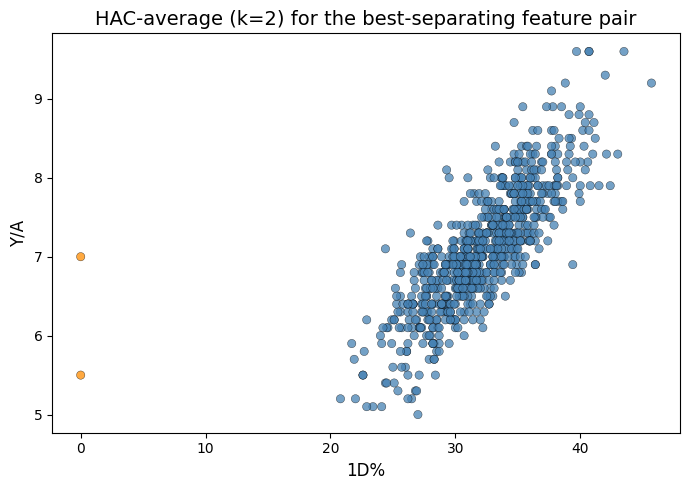

In [34]:
hac_best = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='average', compute_distances=True)
labels_hac_best  = hac_best.fit_predict(data_sc_2)      

best_pair, best_silh_score = None, -1
silh_scores = {}

for f1, f2 in itertools.combinations(data.columns, 2):
    feature_pair = data[[f1, f2]].values
    silh_score = silhouette_score(feature_pair, labels_hac_best) if len(set(labels_hac_best)) > 1 else np.nan
    silh_scores[(f1, f2)] = silh_score
    if silh_score > best_silh_score:
        best_silh_score  = silh_score
        best_pair = (f1, f2)

print(f"Best pair: {best_pair}, Silhouette Score of best pair: {best_silh_score:.3f}")

x_name, y_name = best_pair
plt.figure(figsize=(7,5))
plt.scatter(data[x_name], data[y_name], c=labels_hac_best,
            cmap=ListedColormap(['steelblue', 'darkorange']),
            alpha=0.75, edgecolor='k', linewidth=0.3)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title('HAC-average (k=2) for the best-separating feature pair', fontsize=14)
plt.tight_layout()
plt.show()

**Observations:**
- Almost all passer data points fall into one dense region of the feature pair
- HAC-average put just 2 extreme seasons into their own cluster (it's indeed 2, check in 'data' where feature '1D%' = 0)
- Silhouette is large because the two outliers are very far from the main cloud, so the between-cluster distance is large while the cluster density of the orange cluster is low 

**Meaning/Interpretation:**
- The algorithm isn’t finding two meaningful QB archetypes, it’s simply isolating two outlying passer-season data etries
- Even if average-linkage is more robust to outliers than single- or complete-link, it can still mark outliers or tiny groups as clusters if the gap to the other data points is big enough
- Generally it's hard to visualize the "real" distances as we have a feature space with 24 dimensions

### Question: What would be the result and plot without these 2 outliers? 

As these two passer data points have a first down percentage (1D%) of 0, this could be misleading. Let's remove them and rerun HAC-average for k = 2, to check if the outcome is different!

Best pair: ('TD%_new', 'ANY/A'), Silhouette Score of best pair: 0.461


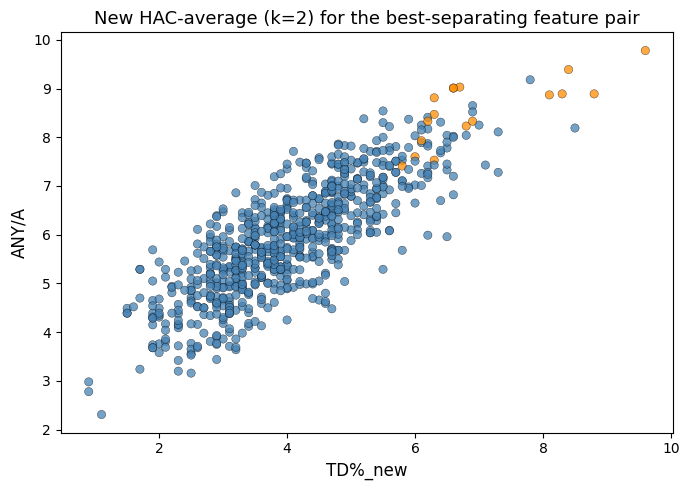

In [35]:
data_new = data[data['1D%']!=0]
scaler_2_new = StandardScaler()
data_sc_2_new = scaler_2_new.fit_transform(data_new)

hac_best = AgglomerativeClustering(n_clusters=2, linkage='average')
labels_hac_best  = hac_best.fit_predict(data_sc_2_new)      

best_pair, best_silh_score = None, -1
silh_scores = {}

for f1, f2 in itertools.combinations(data.columns, 2):
    feature_pair = data_new[[f1, f2]].values
    silh_score = silhouette_score(feature_pair, labels_hac_best) if len(set(labels_hac_best)) > 1 else np.nan
    silh_scores[(f1, f2)] = silh_score
    if silh_score > best_silh_score:
        best_silh_score  = silh_score
        best_pair = (f1, f2)

print(f"Best pair: {best_pair}, Silhouette Score of best pair: {best_silh_score:.3f}")

x_name, y_name = best_pair
plt.figure(figsize=(7,5))
plt.scatter(data_new[x_name], data_new[y_name], c=labels_hac_best,
            cmap=ListedColormap(['steelblue', 'darkorange']),
            alpha=0.75, edgecolor='k', linewidth=0.3)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title('New HAC-average (k=2) for the best-separating feature pair', fontsize=13)
plt.tight_layout()
plt.show()

**Observations:**
- Now another feature pair prints the best silhouette score, but the score itself almost decreased by half!
- Also, now more data points are assigned to the second (orange) cluster
- However there is still no clear clustering structure, so overall we don't get a meaningful result

### Final conclusion on 'data' clusterings:

On the original 24-feature space the algorithms never uncovered a clear pattern. The silhouette scores stayed low or even negative and the HAC-average clustering with k=2, which first seemed to the best choice, just showed one big cluster while 2 outliers split off. Overall, the data don’t separate cleanly, so we’ll turn to the PCA-reduced version 'data_pca' to see whether a better representation with less noise can be found.

### 2. Clusterings for 'data_pca'

**Here the data scaling step is skipped as 'data_pca' was already scaled for PCA in task5. Again, all clusterings use euclidean distance, and the same procedure is repeated, like it was done for 'data'.**

In [36]:
results_data_pca = [] # collect evaluation data for 'data_pca' clusterings

### 2.1 KMeans++

In [37]:
for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=random_state)
    kmeans_labels_pca = kmeans_pca.fit_predict(data_pca.values)
    kmeans_silh_score_pca = silhouette_score(data_pca.values, kmeans_labels_pca, metric='euclidean')
    results_data_pca.append({'Algorithm':'KMeans++', 'k':k, 'MinPts':'-', 'ε':'-', 'Silhouette':kmeans_silh_score_pca})

### 2.3 OPTICS

In [38]:
for MinPts in range(MinPts_low, MinPts_max+1):
    for xi in xis:
        opt_pca = OPTICS(min_samples=MinPts, xi=xi)
        opt_labels_pca = opt_pca.fit_predict(data_pca.values)
        opt_silh_score_pca = silhouette_score(data_pca.values, opt_labels_pca, metric='euclidean') if len(set(opt_labels_pca)) > 1 else np.nan
        results_data_pca.append({'Algorithm':'OPTICS', 'k':'-', 'MinPts':MinPts, 'ε':xi, 'Silhouette':opt_silh_score_pca})

### 2.3 HAC

In [39]:
for link in linkages: 
    for k in k_values:
        hac_pca = AgglomerativeClustering(n_clusters=k, linkage=link)
        hac_labels_pca = hac_pca.fit_predict(data_pca.values)
        hac_silh_score_pca = silhouette_score(data_pca.values, hac_labels_pca, metric='euclidean') if len(set(hac_labels_pca)) > 1 else np.nan
        results_data_pca.append({'Algorithm':f'HAC_{link}', 'k':k, 'MinPts':'-', 'ε':'-', 'Silhouette':hac_silh_score_pca})

### Again, let's have a look on the results

In [40]:
df_res_pca = pd.DataFrame(results_data_pca) #.sort_values('Sil', ascending=False)
df_res_pca

,Algorithm,k,MinPts,ε,Silhouette
0,KMeans++,2,-,-,0.323683
1,KMeans++,3,-,-,0.264989
2,KMeans++,4,-,-,0.250985
3,KMeans++,5,-,-,0.211114
4,KMeans++,6,-,-,0.209894
5,OPTICS,-,4,0.03,-0.308842
6,OPTICS,-,4,0.05,-0.337650
7,OPTICS,-,4,0.08,-0.430055
8,OPTICS,-,5,0.03,-0.386156
9,OPTICS,-,5,0.05,-0.417145


**Observations:**
- KMeans++ improved from 0.27 to 0.32 (comparison to 'data' KMeans++), however the silhouette scores still indicate weak/no structures
- OPTICS performs even worse than for 'data' and produces the lowest silhouette scores again
- HAC with ward-link improved from 0.24 to 0.29, but again prints slightly worse silhouette scores than KMeans++ 
- **Finally, as before HAC with average-link and k=2 leads to the best clustering result with our chosen paramters; but ironically this best silhouette result is now slightly lower than before (from 0.42 to 0.38 $\Rightarrow$ still weak structure)**

**So overall there are no significant changes, which leads us to the same result.**

### Visualization of the best clustering result: again HAC with average-link for k=2

Same principle as for 'data': HAC-average clustering for k = 2 is re-computed to obtain the labels. But now, for every possible feature pair of 'data_pca' (PC1, PC2, PC3, PC4), the silhouette score is calculated by **using those two features only**. The pair with the highest silhouette is then used as the x- and y-axes for the visualisation.

Best pair: ('PC1', 'PC4'), Silhouette Score of best pair: 0.465


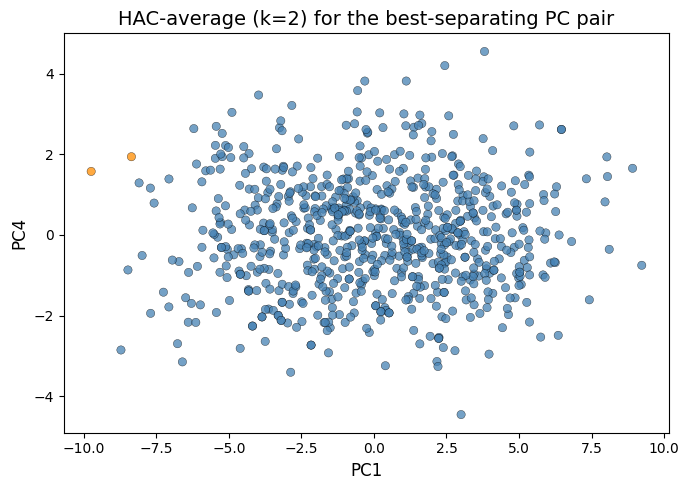

In [41]:
hac_best_pca = AgglomerativeClustering(n_clusters=2, linkage='average')
labels_hac_best_pca  = hac_best_pca.fit_predict(data_pca.values)      

best_pair_pca, best_silh_score_pca = None, -1
silh_scores_pca = {}

for f1, f2 in itertools.combinations(data_pca.columns, 2):
    feature_pair_pca = data_pca[[f1, f2]].values
    silh_score_pca = silhouette_score(feature_pair_pca, labels_hac_best_pca) if len(set(labels_hac_best_pca)) > 1 else np.nan
    silh_scores_pca[(f1, f2)] = silh_score_pca
    if silh_score_pca > best_silh_score_pca:
        best_silh_score_pca  = silh_score_pca
        best_pair_pca = (f1, f2)

print(f"Best pair: {best_pair_pca}, Silhouette Score of best pair: {best_silh_score_pca:.3f}")

x_name_pca, y_name_pca = best_pair_pca
plt.figure(figsize=(7,5))
plt.scatter(data_pca[x_name_pca], data_pca[y_name_pca], c=labels_hac_best_pca,
            cmap=ListedColormap(['steelblue', 'darkorange']),
            alpha=0.75, edgecolor='k', linewidth=0.3)
plt.xlabel(x_name_pca, fontsize=12)
plt.ylabel(y_name_pca, fontsize=12)
plt.title('HAC-average (k=2) for the best-separating PC pair', fontsize=14)
plt.tight_layout()
plt.show()

**Observations:**
- Almost all passer data points fall into one dense region 
- So most passer-season data points lie close together in all four PCs, therefore the algorithm puts them in one cluster
- Again there seem to be 2 outliers, marked orange

**Meaning/Interpretation:**
- The orange outliers might still be extreme in PCs 3 & 4. Average linkage keeps them separate even though their PC1–PC2 coordinates overlap the blue cloud (silhouette is computed in the full 4-D space, so distance to blue cluster might not be visible for us)
- A single big cluster + tiny outlier cluster often inflates silhouette, because the tiny cluster’s within-cluster distance is zero while its distance to the main cluster is relatively large
- Overall HAC-average is showing a few (likely 2) multi-dimensional outliers, not revealing meaningful quarterback archetypes/clusters

### Let's plot the clustering with second highest silhouette score for a comparison: KMeans++ with k=2 

Best feature pair: ('PC1', 'PC4')  (sil = 0.476)


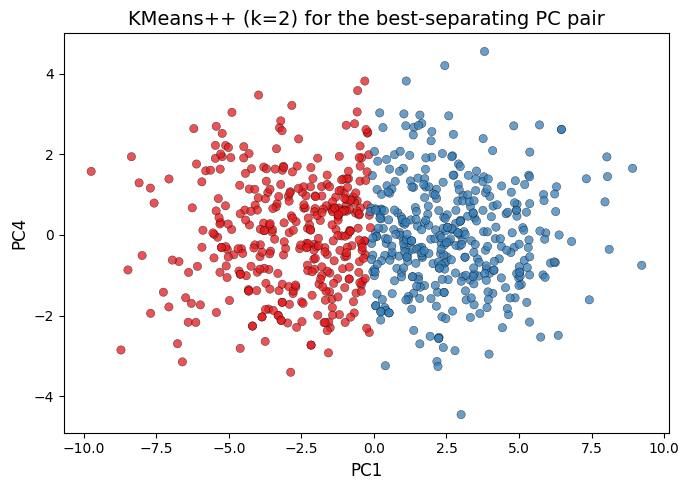

In [42]:
kmeans_pca_new  = KMeans(n_clusters=2, init=init, n_init=n_init, random_state=random_state)
kmeans_labels_pca_new = kmeans_pca_new.fit_predict(data_pca.values)

best_pair, best_pair_sil = None, -1
for f1, f2 in itertools.combinations(data_pca.columns, 2):
    X_pair = data_pca[[f1, f2]].values
    sil    = silhouette_score(X_pair, kmeans_labels_pca_new)
    if sil > best_pair_sil:
        best_pair_sil, best_pair = sil, (f1, f2)

print(f"Best feature pair: {best_pair}  (sil = {best_pair_sil:.3f})")

x_name, y_name = best_pair
n_clusters = len(np.unique(kmeans_labels_pca_new))
cmap = ListedColormap(plt.cm.Set1.colors[:n_clusters])

plt.figure(figsize=(7, 5))
plt.scatter(
    data_pca[x_name], data_pca[y_name],
    c=kmeans_labels_pca_new, cmap=cmap,
    alpha=0.75, edgecolor='k', linewidth=0.3
)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title(f'KMeans++ (k=2) for the best-separating PC pair', fontsize=14)
plt.tight_layout()
plt.show()

**Observation:**
- KMeans++ algorithm basically just splits the data cloud in 2 halfs/parts, as the algorithm tries to find roud shapes of similar sizes
- So this method also doesn't show a meaningful clustering

### Final conclusion on 'data_pca' clusterings:

On the PCA-reduced data HAC-average (k = 2) again isolates just two extreme passer-season data points. No meaningful segmentation is observable, which might be logical considering that the silhouette score is just 0.38, despite being the highest one. The alternative choice KMeans++ (k = 2) doesn't provide a meaningful result as well.

### **Overall takeaway from task 6**

- After multiple trials on both the original feature matrix and the PCA-reduced version, none of the three selected algorithms showed a stable, interpretable cluster structure.
- HAC-average (k = 2) repeatedly isolated just two extreme passer-season data points
- KMeans++ produced roughly equal-sized splits for the PCA version, but the divisions had no clear football meaning
- OPTICS treated most points as noise or formed diffuse mega-clusters

**These results suggest that quarterback passing seasons form a continuum rather than distinct archetypes in which we could fit your quarterback (at least with the features examined). More detailed feature engineering (e.g., era-adjusted efficiency or play-style ratios) or domain-specific altering may be required before meaningful clusters can be found.**